In [168]:
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import gc
import pickle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from tasksim import *
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.cluster import GaussianCluster as GMM
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import time


matplotlib.style.use('ggplot')

In [77]:
def stratified_sample(y, p=0.67, replace=False, seed=1234):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    np.random.seed(seed)
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def split_data(df, p=0.67):
    '''
    Splits dataframe into two dataframes using p value as a proportion. 
    Make sure that all classes are present.
    
    Parameters:
    df: pandas DataFrame, a dataframe to split that has a 'label' column
    p: float, a proprotion in which the dataframe should be splitted
    
    Returns:
    df_1: pandas DataFrame, a dataframe with the first portion of data that is equivalent to p value
    df_2: pandas DataFrame, rest of the data
    
    '''
    main_label_list = df['label'].tolist()
    ind_list = stratified_sample(main_label_list, p)
    df_1 = df[df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    df_2 = df[~df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    
    return df_1, df_2

class IconDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, data_root):
        self.class_names = df['class'].unique().tolist()
        self.image_dir = data_root
        self.transform = transform
        self.total = len(df)
        self.image_names = df['image_path'].to_list()
        self.labels = df['label'].to_numpy()
        self.targets = self.labels
                    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = self.transform(Image.open(image_path).convert('RGB'))
        label = self.labels[idx]
        target = self.labels[idx]
        return image, label

    
image_size = (128, 128)
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    #Normalizing the data to the data that the ResNet18 was trained on
    torchvision.transforms.Normalize(mean = resnet_mean ,
                                    std = resnet_std) 
    
])


#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = resnet_mean,
                                    std = resnet_std) 
    
])

#build model using Resnext50 as backbone
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes, name):
        super().__init__()
        self.name = name
        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.soft(self.base_model(x))

def train_loop(dataloader, model, loss_fn, optimizer, mode="flat", lookup=[], fine_to_coarse={}, 
               batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    counter = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for X_cpu, y_cpu in tepoch:
            counter += 1
            if mode == "fine":
                y_cpu = torch.tensor([lookup.index(i) for i in y_cpu])
            elif mode == "coarse":
                y_cpu = torch.tensor([fine_to_coarse[int(target)] for target in y_cpu])
            X, y = X_cpu.to(device), y_cpu.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y.type(torch.long))
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            avg_loss = train_loss / counter
            tepoch.set_postfix(loss=avg_loss)
    return avg_loss
    
    
def eval_model(dataloader, model, loss_fn, mode="flat", lookup=[], fine_to_coarse={}, 
               return_probab=False, batch_size=64):
    model.eval()
    predicts = []
    targets = []
    val_running_loss = 0.0
    
    for counter, (images, labels) in enumerate(dataloader):
        if mode == "fine":
            labels = torch.tensor([lookup.index(i) for i in labels])
        elif mode == "coarse":
            labels = torch.tensor([fine_to_coarse[int(i)] for i in labels])
        else:
            labels = torch.tensor(labels)
        imageGPU = images.to(device)
        
        outputs = torch.Tensor.cpu(model(imageGPU))
        loss = loss_fn(outputs, labels.type(torch.long))
        val_running_loss += loss.item()
        predicts.append(outputs.detach().numpy())
        targets.append(labels)
    val_loss = val_running_loss / counter  
    predicts = np.vstack(predicts)
    targets = np.hstack(targets)
    if return_probab:
        return predicts, targets
    else:
        predicts = np.argmax(predicts, axis=1)
        return val_loss, accuracy_score(targets, predicts)

    

def train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,
                       mode="flat", fine_to_coarse={}, coarse_label=None, lookup=[], 
                       model_path = None):

    early_stopping=EarlyStopping()
    #lr_scheduler = LRScheduler(optimizer)
    
    if model_path is None:
        model_path = '/models/%s.pth' %model.name
    min_loss= 1000
    max_acc = 0
    train_loss= []
    val_loss, val_accuracy = [], []
    for t in range(epochs):
        if mode == "fine":
            print(f"Coarse label {coarse_label} Epoch {t+1}\n-------------------------------")
        else:
            print(f"Epoch {t+1}\n-------------------------------")
        train_epoch_loss = train_loop(train_dl, model, loss_fn, optimizer, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        val_epoch_loss, val_epoch_acc = eval_model(val_dl, model,loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        if val_epoch_loss < min_loss:
            max_acc = val_epoch_acc
            min_loss = val_epoch_loss
            torch.save(model.state_dict(), model_path)
        elif val_epoch_acc>max_acc:
            max_acc = val_epoch_acc
            torch.save(model.state_dict(), model_path)
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
        print("train loss %s, validation loss %s, validation accuracy %s" %(train_epoch_loss, 
                                                                            val_epoch_loss, 
                                                                            val_epoch_acc))
    test_loss, test_acc = eval_model(test_dl, model, loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
    print("Done! Saved model with test accuracy %s and loss %s" %(test_acc, test_loss))
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(val_accuracy, color='blue', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"models/validationAccuracy_{model.name}.png")
    plt.show()
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"models/losses_{model.name}.png")
    plt.show()
    
    return  test_acc


In [12]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [13]:
#take any model, use its penultimate layer as output features
def extract_features_targets(model, dl):    
    tt = model.base_model
    modules=list(tt.children())[:-1]
    feature_extractor = torch.nn.Sequential(*modules)
    for p in feature_extractor.parameters():
        p.requires_grad = False

    feature_extractor.to(device)
    features = []
    targets = []
    for val_step, (images, labels) in enumerate(dl):
        imagesGPU = images.to(device)      
        outputs = feature_extractor(imagesGPU)        
        outputs = torch.Tensor.cpu(outputs)
        outputs = outputs.detach().numpy()
        features.append(outputs)
        targets.append(labels)
        
    features = np.vstack(features)
    targets = np.hstack(targets)
    dim = features.shape[1]
    features= features.reshape(len(dl.dataset), dim)
    torch.cuda.empty_cache()
    return features, targets

In [24]:
# utils for cluster generation
class Dataset:
    def __init__(self, file='data/icons_embd.p', train=True, classes=[]):

        self.data = pickle.load(open(file, 'rb'))[0] 
        self.targets = pickle.load(open(file, 'rb'))[1]       
        self.classes = classes

In [33]:
def create_label_dictionaries(cluster_list):
    """Creates dictionaries from coarse to fine, from fine to coarse and concatenated list 
    of fine clusters
    
    Parameters:
    cluster_list: list
        A list where the index of the element represents the fine label and the value represents
        the coarse label(cluster)    
    """
    fine_to_coarse = {i:v for i,v in enumerate(cluster_list)}
    coarse_to_fine = defaultdict(list)
    for k, v in fine_to_coarse.items():
        coarse_to_fine[v].append(k)
    return fine_to_coarse, coarse_to_fine

In [56]:
seeds = [1234,6265, 2403, 941,2225]

#learning rate is the same for all models
learning_rate = 1e-4 

label_noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [63]:
### Create a single dataframe with splitting data into fine-tune, 
### train, validation and test for all 5 runs

# process data
data_path = Path('../../../data/testdotai/')
image_paths = [path for path in data_path.glob("*/*.jpg")]  
print(len(image_paths))
x_col_name = "image_path"
y_col_name = "class"
df = pd.DataFrame({x_col_name: image_paths})
df[y_col_name] = df[x_col_name].map(lambda x: x.parent.stem)
df[x_col_name] = df[x_col_name].map(lambda x: str(x))

# Filter out small classes under 250 samples and '_negative' class
class_l = df['class'].tolist()
unique_y, counts = np.unique(class_l, return_counts=True)
small = [unique_y[i] for i,v in enumerate(counts) if v < 250 ]+['_negative']
filtered_df = df[~df['class'].isin(small)].reset_index(drop=True)
print(len(filtered_df))

#create labels to classes and back dictionaries
n_classes = len(filtered_df['class'].unique())
classes_to_labels = {}
for i, label in enumerate(filtered_df['class'].unique()):
    classes_to_labels[label] = i
labels_to_classes = {v:k for k,v in classes_to_labels.items()}

with open('../../../teamdrive/transmediasp/kate/icon_label_to_class_dict.p', 'wb') as handle:
    pickle.dump(labels_to_classes, handle)
    
filtered_df['label'] = filtered_df['class'].apply(lambda x: classes_to_labels[x])


153378
141642


In [124]:
#generate split to fine-tune, test and main(train) data
for i, seed in enumerate(seeds):
    label_list = filtered_df['label'].tolist()
    inds_list = np.array(filtered_df.index)
    fine_inds = stratified_sample(label_list, p=0.05, seed=seed)
    rest_inds = inds_list[~np.isin(inds_list,fine_inds)]
    rest_labels = [label_list[i] for i in rest_inds]
    temp_inds = stratified_sample(rest_labels, p=0.1, seed=seed)
    test_inds = np.take_along_axis(rest_inds,temp_inds, axis=None)
    filtered_df['run_%s' %i] = ['fine' if x in fine_inds 
                                  else 'test' if x in test_inds 
                                  else 'main' for x in filtered_df.index]

In [154]:
#add noise to labels for all the runs
for run,seed in enumerate(seeds):
    main_inds = np.array(filtered_df[filtered_df['run_%s' %run] == 'main'].index)
    for label_noise in label_noises:
        label_str = str(int(label_noise*100))
        np.random.seed(seed)
        size = int(label_noise * len(main_inds))
        noise_idx = np.random.choice(len(main_inds), size, replace=False)
        noise_inds = np.take_along_axis(main_inds,noise_idx, axis=None)
        print('injecting noise ...%s, run %s' %(len(noise_idx), run))
        filtered_df['label_%s_%s' %(run, label_str)] = [np.random.randint(n_classes) if x in noise_inds 
                                                        else filtered_df['label'].iat[x] for x in filtered_df.index]
        
filtered_df.to_csv('../../../teamdrive/transmediasp/kate/icons_df.csv')

injecting noise ...12117, run 0
injecting noise ...24235, run 0
injecting noise ...36353, run 0
injecting noise ...48470, run 0
injecting noise ...60588, run 0
injecting noise ...72706, run 0
injecting noise ...84823, run 0
injecting noise ...96941, run 0
injecting noise ...109059, run 0
injecting noise ...12117, run 1
injecting noise ...24235, run 1
injecting noise ...36353, run 1
injecting noise ...48470, run 1
injecting noise ...60588, run 1
injecting noise ...72706, run 1
injecting noise ...84823, run 1
injecting noise ...96941, run 1
injecting noise ...109059, run 1
injecting noise ...12117, run 2
injecting noise ...24235, run 2
injecting noise ...36353, run 2
injecting noise ...48470, run 2
injecting noise ...60588, run 2
injecting noise ...72706, run 2
injecting noise ...84823, run 2
injecting noise ...96941, run 2
injecting noise ...109059, run 2
injecting noise ...12117, run 3
injecting noise ...24235, run 3
injecting noise ...36353, run 3
injecting noise ...48470, run 3
injec

In [150]:
filtered_df.head(20)


,image_path,class,label,run_0,run_1,run_2,run_3,run_4,label_0_10
0,../../../data/testdotai/close/_e4530e1aae88750...,close,0,main,main,main,main,main,0
1,../../../data/testdotai/close/~02a0c54fd8374b4...,close,0,main,main,main,main,main,0
2,../../../data/testdotai/close/_10099f88fd8333f...,close,0,main,fine,main,main,main,0
3,../../../data/testdotai/close/_bcd740021f1a62a...,close,0,main,test,main,fine,test,0
4,../../../data/testdotai/close/_047b3f69c7c53b8...,close,0,main,main,main,test,main,0
5,../../../data/testdotai/close/_530464eb7c56a08...,close,0,main,test,main,main,fine,0
6,../../../data/testdotai/close/_b9fca4f2b106c1f...,close,0,main,main,main,fine,main,0
7,../../../data/testdotai/close/~9414624116f8235...,close,0,main,test,main,main,test,0
8,../../../data/testdotai/close/~b8a44d79b1165ed...,close,0,main,main,main,test,test,0
9,../../../data/testdotai/close/_def90b0d68090cb...,close,0,main,main,main,main,main,0


In [179]:
data = pd.read_csv('../../../teamdrive/transmediasp/kate/hierarchy/label_noise_data_frame_with_splits.csv')
data['split_00_0']

KeyError: 'split_00_0'

In [177]:
data = pickle.load(open('../../../teamdrive/transmediasp/kate/hierarchy/label_noise_data_frame_with_splits.p', 'rb'))
data

TypeError: __cinit__() takes at least 2 positional arguments (0 given)

In [156]:
torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  

In [165]:
for run,seed in enumerate(seeds):
    if run==0:
        pass
    else:
        #set manual seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        #prepare data
        fine_tune_df = filtered_df[filtered_df['run_%s' %run]== 'fine']
        fine_tune_dataset = IconDataset(fine_tune_df, train_transform, "")
        dl_fine_tune = torch.utils.data.DataLoader(fine_tune_dataset, batch_size=batch_size, shuffle=False)

        main_df = filtered_df[filtered_df['run_%s' %run]== 'main']
        main_dataset = IconDataset(main_df, train_transform, "")
        dl_main = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size, shuffle=False)

        #fine tune Resnet and extract features    
        print('Starting fine tuning...')
        epochs= 3

        # Initialize the model
        model = Resnext50(n_classes, name="icons_fine_tuned_model_%s" %run)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)

        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loss = train_loop(dl_fine_tune, model, loss_fn, optimizer, batch_size=batch_size)
        torch.save(model,'../../../teamdrive/transmediasp/kate/models/%s.pth' %model.name)
        print('Done with fine tuning round %s' %run)

        #extract an embedding
        print("Preparing an embedding...")
        features, targets = extract_features_targets(model, dl_main)
        with open('../../../teamdrive/transmediasp/kate/hierarchy/icons_embd_%s.p' %run , 'wb') as handle:
            pickle.dump((features, targets), handle)
        print("Done with the embedding")

Starting fine tuning...
Epoch 1
-------------------------------


100%|██████████| 111/111 [00:44<00:00,  2.52batch/s, loss=4.55]


Epoch 2
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.53batch/s, loss=4.55]


Epoch 3
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.54batch/s, loss=4.54]


Done with fine tuning round 1
Preparing an embedding...
Done with the embedding
Starting fine tuning...
Epoch 1
-------------------------------


100%|██████████| 111/111 [00:44<00:00,  2.50batch/s, loss=4.55]


Epoch 2
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.55batch/s, loss=4.55]


Epoch 3
-------------------------------


100%|██████████| 111/111 [00:47<00:00,  2.35batch/s, loss=4.54]


Done with fine tuning round 2
Preparing an embedding...
Done with the embedding
Starting fine tuning...
Epoch 1
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.53batch/s, loss=4.55]


Epoch 2
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.54batch/s, loss=4.55]


Epoch 3
-------------------------------


100%|██████████| 111/111 [00:44<00:00,  2.51batch/s, loss=4.54]


Done with fine tuning round 3
Preparing an embedding...
Done with the embedding
Starting fine tuning...
Epoch 1
-------------------------------


100%|██████████| 111/111 [00:44<00:00,  2.49batch/s, loss=4.55]


Epoch 2
-------------------------------


100%|██████████| 111/111 [00:43<00:00,  2.55batch/s, loss=4.55]


Epoch 3
-------------------------------


100%|██████████| 111/111 [00:44<00:00,  2.51batch/s, loss=4.54]


Done with fine tuning round 4
Preparing an embedding...
Done with the embedding


In [169]:
df_dataset = IconDataset(filtered_df, test_transform, "")
dl_df = torch.utils.data.DataLoader(df_dataset, batch_size=batch_size, shuffle=False)


In [171]:
emb_model = torch.load('../../../teamdrive/transmediasp/kate/models/icons_fine_tuned_model_0.pth')
#extract an embedding
print("Preparing an embedding...")
features, targets = extract_features_targets(emb_model, dl_df)
with open('../../../teamdrive/transmediasp/kate/hierarchy/icons_embd_whole.p', 'wb') as handle:
    pickle.dump((features, targets), handle)
print("Done with the embedding")

Preparing an embedding...
Done with the embedding


In [172]:
len(targets)

141642

In [180]:
resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [181]:
emb_model = torch.load('../../../teamdrive/transmediasp/kate/models/icons_fine_tuned_model_0.pth')
emb_model

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [185]:
torch.save(emb_model.state_dict(), '../../../teamdrive/transmediasp/kate/models/icons_fine_tuned_model.pth')

In [20]:
# not needed in the full run
emb = pickle.load(open('../../../teamdrive/transmediasp/kate/icons_embd_%s_%s.p' % (label_noise, round_no), 'rb'))
emb

(array([[0.0616513 , 0.36202168, 0.        , ..., 0.4462993 , 0.09106986,
         0.4948197 ],
        [1.376514  , 1.3281671 , 0.46987063, ..., 0.56508607, 0.05058002,
         0.        ],
        [0.20250276, 0.5982305 , 0.38181028, ..., 0.        , 0.65545523,
         0.7694685 ],
        ...,
        [0.8143283 , 0.7912186 , 0.        , ..., 0.44989085, 0.8429706 ,
         0.0091788 ],
        [0.27688396, 0.12154385, 0.5560533 , ..., 0.592415  , 0.51375395,
         0.09062979],
        [0.        , 2.0333414 , 0.03623103, ..., 0.0034996 , 0.        ,
         0.06566058]], dtype=float32),
 array([87, 31, 41, ..., 42, 29, 17]))

In [16]:
main_df, test_df = split_data(filtered_df, p=0.9)
valid_df, train_df  = split_data(main_df, p=0.11112)
fine_tune_df, _ = split_data(train_df, p=0.1)

In [17]:
# prepare dataloaders
batch_size = 64

test_dataset = IconDataset(test_df, test_transform, "")
train_dataset = IconDataset(train_df, train_transform, "")
validation_dataset = IconDataset(valid_df, train_transform, "")
fine_tune_dataset = IconDataset(fine_tune_df, train_transform, "")

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dl_valid = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
dl_fine_tune = torch.utils.data.DataLoader(fine_tune_dataset, batch_size=batch_size, shuffle=False)



In [18]:
noises = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
label_noise = 0.0
round_no  = 1

In [15]:
#create a dictionary to save results in
result_accuracies = defaultdict()



153378


In [19]:
result_accuracies["%s" %label_noise] = {'flat':defaultdict(), 'hierarchical_no_noise': defaultdict(), 'hierarchical_noisy': defaultdict()}


  0%|          | 0/1771 [00:00<?, ?batch/s]

Epoch 1
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 4.041605401618005, validation loss 3.946784315325997, validation accuracy 0.6355788281913388
Epoch 2
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.918210665295179, validation loss 3.9200546286322853, validation accuracy 0.6604868383809793
Epoch 3
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.885596032333805, validation loss 3.8821719603105023, validation accuracy 0.6977073308802717
Epoch 4
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.848222534512477, validation loss 3.864095518805764, validation accuracy 0.7162468157373337
Epoch 5
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.8329615101580026, validation loss 3.8566882772879167, validation accuracy 0.7231106708180017
Epoch 6
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.814033356579867, validation loss 3.8349293459545484, validation accuracy 0.7454712708746108
Epoch 7
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.8024790627615794, validation loss 3.8258399920030075, validation accuracy 0.7535380696292103
Epoch 8
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.793122423765418, validation loss 3.820332225886258, validation accuracy 0.7587744126804415
Epoch 9
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.787519282637714, validation loss 3.8138143051754345, validation accuracy 0.766133597509199
Epoch 10
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.7801845675467907, validation loss 3.8113285682418128, validation accuracy 0.7681149165015567
Epoch 11
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.776101790465318, validation loss 3.8029817559502344, validation accuracy 0.776110953863572
Epoch 12
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

INFO: Early stopping counter 1 of 5
train loss 3.7728590351386906, validation loss 3.807426735487851, validation accuracy 0.7715114633455986
Epoch 13
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.7703712401182754, validation loss 3.802415691722523, validation accuracy 0.7763939994339089
Epoch 14
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.765638833662536, validation loss 3.7988573551177978, validation accuracy 0.7799320690631192
Epoch 15
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.759462188826248, validation loss 3.7935251777822323, validation accuracy 0.7860175488253609
Epoch 16
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

INFO: Early stopping counter 2 of 5
train loss 3.756204281332532, validation loss 3.795931987328963, validation accuracy 0.7836116614774978
Epoch 17
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

INFO: Early stopping counter 3 of 5
train loss 3.7551089830145465, validation loss 3.796363505450162, validation accuracy 0.7830455703368242
Epoch 18
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

INFO: Early stopping counter 4 of 5
train loss 3.7531007235498497, validation loss 3.7955518570813265, validation accuracy 0.7842485140107557
Epoch 19
-------------------------------


  0%|          | 0/1771 [00:00<?, ?batch/s]

train loss 3.751548115511118, validation loss 3.7926929007877, validation accuracy 0.7868666855363714
Epoch 20
-------------------------------


100%|██████████| 1771/1771 [11:35<00:00,  2.55batch/s, loss=3.75]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.7804929577464789 and loss 3.7988660022683813


FileNotFoundError: [Errno 2] No such file or directory: '/models/validation_accuracy_base_model_Resnext50_icons.png'

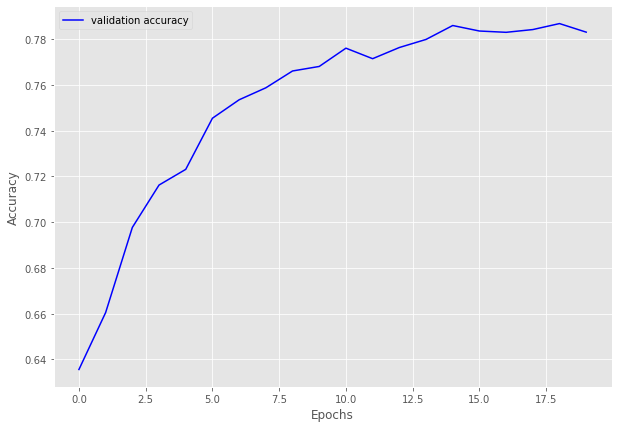

In [11]:
# train flat model 
epochs= 40
result_accuracies = {}

model = Resnext50(n_classes, name="base_model_Resnext50_icons")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                    dl_train, dl_test, dl_valid,
                                                    model_path = '../../../teamdrive/transmediasp/kate/models/base/%s.pth' %model.name )
result_accuracies['0.0']['flat'] = test_accuracy
with open('../../../teamdrive/transmediasp/kate/result_accuracies_round_1.p', 'wb') as handle:
    pickle.dump(result_accuracies, handle)



In [25]:
#generate clusters 
print("Generating clusters...")
file = '../../../teamdrive/transmediasp/kate/icons_embd_%s_%s.p' % (label_noise, round_no)
trainset = Dataset(file)

In [28]:
n_props = 1

generate_dist_matrix_kwargs = {'metric':'tasksim', 
                               'metric_kwargs':{'n_neg_classes': 10, 
                                                'task_similarity_kwargs': {'transformer_kwargsx': 
                                                                               {'max_depth':4},
                                                                          'transformer_kwargsz':
                                                                              {'max_depth':4}}}, 
                               'function_tuples':None, 
                               'n_cores':5, 
                               'acorn':None
                              }


process_dist_matrix_kwargs = {'make_symmetric': True,
                              'scale':True,
                             'aug_diag':True,
                             }

embedding=ASE
embedding_kwargs={'n_components':16}
cluster=GMM
cluster_kwargs = {'min_components': 20, 'max_components': 20, 'reg_covar': 1e-03}

cluster_dists_kwargs = {'embedding':embedding, 
                        'embedding_kwargs':embedding_kwargs, 
                        'cluster':cluster, 
                        'cluster_kwargs':cluster_kwargs
                       }

In [ ]:
n_mc=1
master_seed = acorn
np.random.seed(master_seed)

data_dimension=2048

generate_tasksim=True

if generate_tasksim:
    tasksim_clusters = []
    
#- Generate clusters
for iteration in tqdm(range(n_mc)):
    start = time.time()
    X_train, _, y_train, _ = train_test_split(trainset.data, trainset.targets, test_size=1, random_state=acorn)
    print(len(X_train), len(y_train))
    if generate_tasksim:
        temp_tasksim = generate_hierarchy(X_train, y_train, generate_dist_matrix_kwargs, process_dist_matrix_kwargs, cluster_dists_kwargs)
        tasksim_clusters.append(temp_tasksim)
        
        pickle.dump(tasksim_clusters, open('../../../teamdrive/transmediasp/kate/icons_tasksim_clusters_%s_%s.p' % (label_noise, round_no), 'wb'))
print("Clusters are generated")   


  0%|          | 0/1 [00:00<?, ?it/s]

113309 113309


In [32]:
len(tasksim_clusters[0])

94

In [ ]:
#Prepare data for a coarse classifier training
fine_to_coarse, coarse_to_fine = create_label_dictionaries(tasksim_clusters[0])

number_of_clusters = len(coarse_to_fine.keys())
overall_accuracy={}

stacked_fine_labels = []
for i in range(0, number_of_clusters):
    stacked_fine_labels +=coarse_to_fine[i]

Epoch 1
-------------------------------


100%|██████████| 1771/1771 [13:21<00:00,  2.21batch/s, loss=2.42]


train loss 2.4188796505963044, validation loss 2.3764758348464965, validation accuracy 0.7135578828191339
Epoch 2
-------------------------------


100%|██████████| 1771/1771 [11:50<00:00,  2.49batch/s, loss=2.35]


train loss 2.354530399092034, validation loss 2.3460608384825967, validation accuracy 0.7428530993489952
Epoch 3
-------------------------------


100%|██████████| 1771/1771 [20:48<00:00,  1.42batch/s, loss=2.32]


train loss 2.320575292604512, validation loss 2.316855892268094, validation accuracy 0.7715822247381828
Epoch 4
-------------------------------


100%|██████████| 1771/1771 [11:50<00:00,  2.49batch/s, loss=2.3] 


train loss 2.303733987232038, validation loss 2.309838248382915, validation accuracy 0.7791536937446929
Epoch 5
-------------------------------


100%|██████████| 1771/1771 [11:45<00:00,  2.51batch/s, loss=2.3]


train loss 2.2967313219099514, validation loss 2.3074918129227378, validation accuracy 0.7812765355222191
Epoch 6
-------------------------------


100%|██████████| 1771/1771 [12:56<00:00,  2.28batch/s, loss=2.29]


train loss 2.290757342020312, validation loss 2.301703450896523, validation accuracy 0.7870789697141239
Epoch 7
-------------------------------


100%|██████████| 1771/1771 [20:51<00:00,  1.42batch/s, loss=2.29]


train loss 2.285278529113864, validation loss 2.29441350590099, validation accuracy 0.7936597792244552
Epoch 8
-------------------------------


100%|██████████| 1771/1771 [11:46<00:00,  2.51batch/s, loss=2.28]


INFO: Early stopping counter 1 of 5
train loss 2.2792544017600043, validation loss 2.3023424517024647, validation accuracy 0.7862298330031136
Epoch 9
-------------------------------


100%|██████████| 1771/1771 [13:45<00:00,  2.14batch/s, loss=2.28]


INFO: Early stopping counter 2 of 5
train loss 2.276876512319607, validation loss 2.2961747657168994, validation accuracy 0.7923860741579394
Epoch 10
-------------------------------


100%|██████████| 1771/1771 [11:42<00:00,  2.52batch/s, loss=2.27]


train loss 2.274799962961896, validation loss 2.2908410267396406, validation accuracy 0.7979762241720917
Epoch 11
-------------------------------


100%|██████████| 1771/1771 [21:59<00:00,  1.34batch/s, loss=2.27]


train loss 2.270256622977879, validation loss 2.2900387232953854, validation accuracy 0.7984715539201811
Epoch 12
-------------------------------


100%|██████████| 1771/1771 [11:43<00:00,  2.52batch/s, loss=2.27]


INFO: Early stopping counter 3 of 5
train loss 2.267447302800528, validation loss 2.290291697328741, validation accuracy 0.798400792527597
Epoch 13
-------------------------------


100%|██████████| 1771/1771 [13:41<00:00,  2.15batch/s, loss=2.26]


train loss 2.2553146950341025, validation loss 2.2695953965187075, validation accuracy 0.8189923577696009
Epoch 14
-------------------------------


100%|██████████| 1771/1771 [13:13<00:00,  2.23batch/s, loss=2.25]


INFO: Early stopping counter 4 of 5
train loss 2.2480464882260995, validation loss 2.271142553199421, validation accuracy 0.81729408434758
Epoch 15
-------------------------------


100%|██████████| 1771/1771 [17:58<00:00,  1.64batch/s, loss=2.24]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8200704225352112 and loss 2.2682789019330056


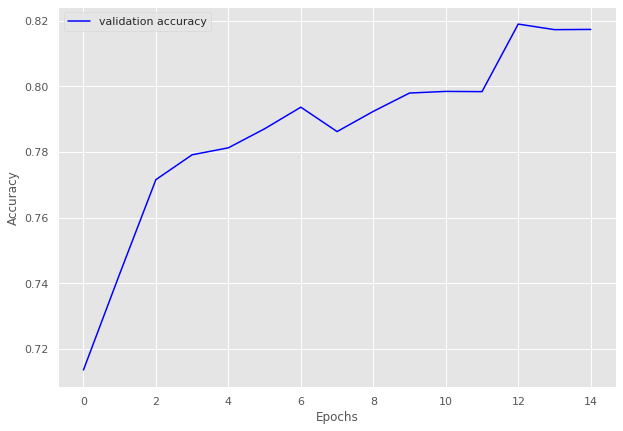

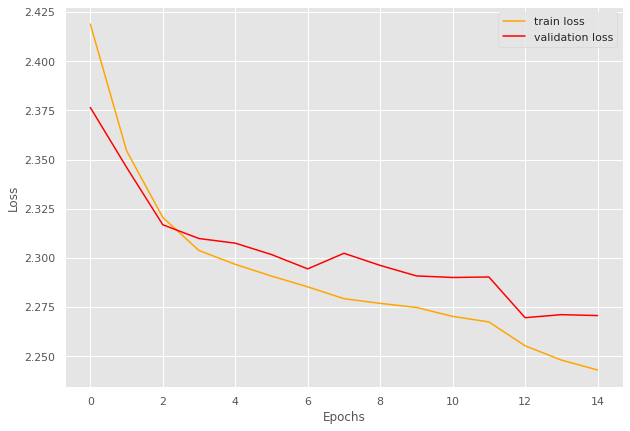

coarse accuracy 0.8200704225352112


In [46]:
epochs= 40
label_noise_str = str(label_noise).replace(".", "")
model = Resnext50(number_of_clusters, name="hierarchical_coarse_model_Resnext50_icons_%s_round%s" %(label_noise_str, round_no))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

coarse_test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                    dl_train, dl_test, dl_valid,mode="coarse", fine_to_coarse=fine_to_coarse,
                                                    model_path = '../../../teamdrive/transmediasp/kate/models/hierarchical/%s.pth' %model.name )

print("coarse accuracy %s" %coarse_test_accuracy)

In [47]:
def filter_data(training_data, test_data, filter_by_coarse=False, 
                coarse_label=None, coarse_to_fine=None, valid_size=0.1, batch_size=64, data_fraction=1.0, seed=1234):
    """Filters datasets by coarse label if needed and split to train and validation subsets"""
    np.random.seed(seed)
    size = int(data_fraction * len(training_data))
    sample_idx = np.random.choice(len(training_data), size, replace=False)
    print('sampling data ...%s' %len(sample_idx))
    
    if filter_by_coarse:
        labels = coarse_to_fine[coarse_label]
        indices = [idx for idx,v in enumerate(training_data.targets) if v in labels and idx in sample_idx]
        indices_test = [idx for idx,v in enumerate(test_data.targets) if v in labels]     
    else:
        indices = sample_idx
        indices_test = [i for i in range(len(test_data.targets))]
    validate_len = int(len(indices)*valid_size)
    validate_filter_indices = random.sample(range(0,len(indices)), validate_len)
    indices_val = [indices[i] for i in validate_filter_indices]  
    indices_train = [v for i,v in enumerate(indices) if i not in validate_filter_indices]    
        
    train = data_utils.Subset(training_data, indices_train)
    validate = data_utils.Subset(training_data, indices_val)
    test = data_utils.Subset(test_data, indices_test)
    
    train_dl = DataLoader(train,  batch_size=batch_size, shuffle=True)
    validate_dl = DataLoader(validate, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test,  batch_size=batch_size, shuffle=True)
    return train_dl, validate_dl, test_dl

In [48]:
main_dataset = IconDataset(main_df, train_transform, "")

sampling data ...127442
Coarse label 0 Epoch 1
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.93]


train loss 1.933958060277177, validation loss 1.8947873657399958, validation accuracy 0.8532280538783094
Coarse label 0 Epoch 2
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.82]


train loss 1.8154523345110047, validation loss 1.855902697100784, validation accuracy 0.8913144449605203
Coarse label 0 Epoch 3
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.79]


train loss 1.793197230930769, validation loss 1.840869123285467, validation accuracy 0.9024616813748259
Coarse label 0 Epoch 4
-------------------------------


100%|██████████| 303/303 [02:02<00:00,  2.47batch/s, loss=1.78]


train loss 1.7801179665543458, validation loss 1.835297577308886, validation accuracy 0.9098931723176963
Coarse label 0 Epoch 5
-------------------------------


100%|██████████| 303/303 [02:00<00:00,  2.51batch/s, loss=1.77]


train loss 1.7698515932945529, validation loss 1.8283015128337976, validation accuracy 0.9150023223409196
Coarse label 0 Epoch 6
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.76]


INFO: Early stopping counter 1 of 5
train loss 1.7586029539800714, validation loss 1.8301419669931585, validation accuracy 0.9140733859730609
Coarse label 0 Epoch 7
-------------------------------


100%|██████████| 303/303 [02:02<00:00,  2.48batch/s, loss=1.75]


train loss 1.750876792980106, validation loss 1.8262355580474392, validation accuracy 0.9173246632605666
Coarse label 0 Epoch 8
-------------------------------


100%|██████████| 303/303 [03:21<00:00,  1.51batch/s, loss=1.75]


train loss 1.746694811893375, validation loss 1.8219387531280518, validation accuracy 0.9205759405480725
Coarse label 0 Epoch 9
-------------------------------


100%|██████████| 303/303 [02:24<00:00,  2.10batch/s, loss=1.74]


train loss 1.7436006981940946, validation loss 1.8147634665171306, validation accuracy 0.9275429633070135
Coarse label 0 Epoch 10
-------------------------------


100%|██████████| 303/303 [02:00<00:00,  2.51batch/s, loss=1.74]


train loss 1.7425994991075875, validation loss 1.8137643192753647, validation accuracy 0.927078495123084
Coarse label 0 Epoch 11
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.74]


INFO: Early stopping counter 2 of 5
train loss 1.740933345095946, validation loss 1.8199393604740952, validation accuracy 0.9228982814677195
Coarse label 0 Epoch 12
-------------------------------


100%|██████████| 303/303 [02:00<00:00,  2.51batch/s, loss=1.74]


INFO: Early stopping counter 3 of 5
train loss 1.735869873474927, validation loss 1.8247508099584868, validation accuracy 0.920111472364143
Coarse label 0 Epoch 13
-------------------------------


100%|██████████| 303/303 [02:02<00:00,  2.48batch/s, loss=1.74]


INFO: Early stopping counter 4 of 5
train loss 1.735028061142849, validation loss 1.8150285663026753, validation accuracy 0.9280074314909429
Coarse label 0 Epoch 14
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.49batch/s, loss=1.73]


train loss 1.732071346969101, validation loss 1.8099842938509854, validation accuracy 0.9307942405945193
Coarse label 0 Epoch 15
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.49batch/s, loss=1.73]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9253233208176888 and loss 1.813113183588595


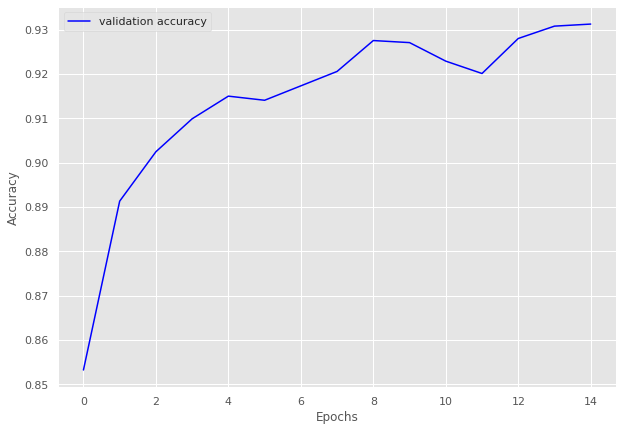

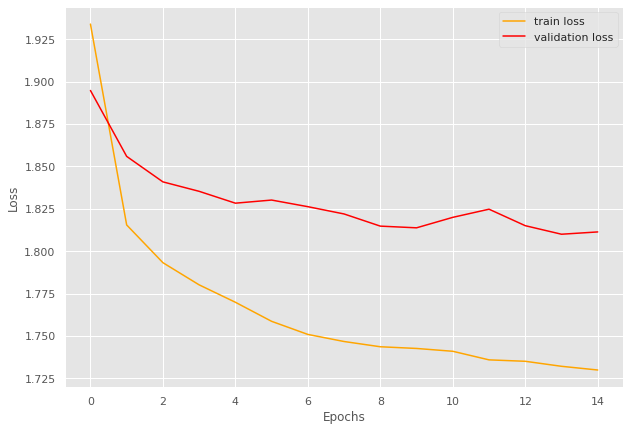

sampling data ...127442
Coarse label 1 Epoch 1
-------------------------------


100%|██████████| 38/38 [00:51<00:00,  1.37s/batch, loss=0.656]


train loss 0.6562634533957431, validation loss 0.7050128430128098, validation accuracy 0.9887218045112782
Coarse label 1 Epoch 2
-------------------------------


100%|██████████| 38/38 [00:52<00:00,  1.38s/batch, loss=0.572]


train loss 0.5719323205320459, validation loss 0.7024535238742828, validation accuracy 0.9887218045112782
Coarse label 1 Epoch 3
-------------------------------


100%|██████████| 38/38 [00:51<00:00,  1.36s/batch, loss=0.569]


train loss 0.5690303272322604, validation loss 0.7014784514904022, validation accuracy 0.9887218045112782
Coarse label 1 Epoch 4
-------------------------------


100%|██████████| 38/38 [00:50<00:00,  1.34s/batch, loss=0.565]


INFO: Early stopping counter 1 of 5
train loss 0.5651880236048448, validation loss 0.7217054069042206, validation accuracy 0.9887218045112782
Coarse label 1 Epoch 5
-------------------------------


100%|██████████| 38/38 [00:51<00:00,  1.35s/batch, loss=0.562]


INFO: Early stopping counter 2 of 5
train loss 0.5620950225152468, validation loss 0.7071609795093536, validation accuracy 0.981203007518797
Coarse label 1 Epoch 6
-------------------------------


100%|██████████| 38/38 [00:51<00:00,  1.35s/batch, loss=0.566]


train loss 0.5657369902259425, validation loss 0.6983864903450012, validation accuracy 0.9924812030075187
Coarse label 1 Epoch 7
-------------------------------


100%|██████████| 38/38 [00:57<00:00,  1.51s/batch, loss=0.561]


train loss 0.5611972275533175, validation loss 0.6975693106651306, validation accuracy 0.9924812030075187
Coarse label 1 Epoch 8
-------------------------------


100%|██████████| 38/38 [00:53<00:00,  1.42s/batch, loss=0.56] 


train loss 0.5602935819249404, validation loss 0.6971062570810318, validation accuracy 0.9924812030075187
Coarse label 1 Epoch 9
-------------------------------


100%|██████████| 38/38 [00:59<00:00,  1.58s/batch, loss=0.555]


INFO: Early stopping counter 3 of 5
train loss 0.5550464909327658, validation loss 0.6981674432754517, validation accuracy 0.9887218045112782
Coarse label 1 Epoch 10
-------------------------------


100%|██████████| 38/38 [00:56<00:00,  1.50s/batch, loss=0.559]


INFO: Early stopping counter 4 of 5
train loss 0.5588036932443318, validation loss 0.6976694613695145, validation accuracy 0.9924812030075187
Coarse label 1 Epoch 11
-------------------------------


100%|██████████| 38/38 [00:48<00:00,  1.28s/batch, loss=0.567]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9932659932659933 and loss 0.6980180889368057


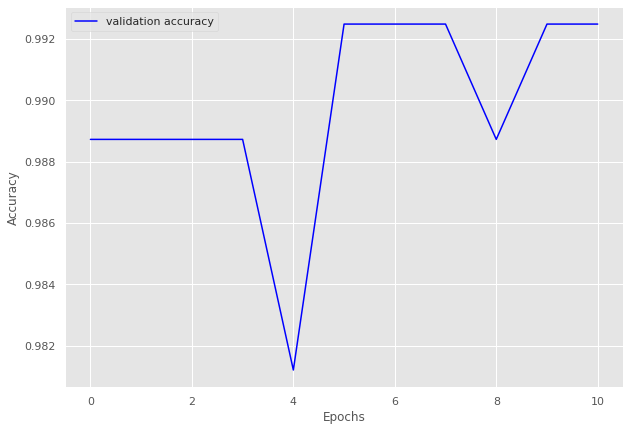

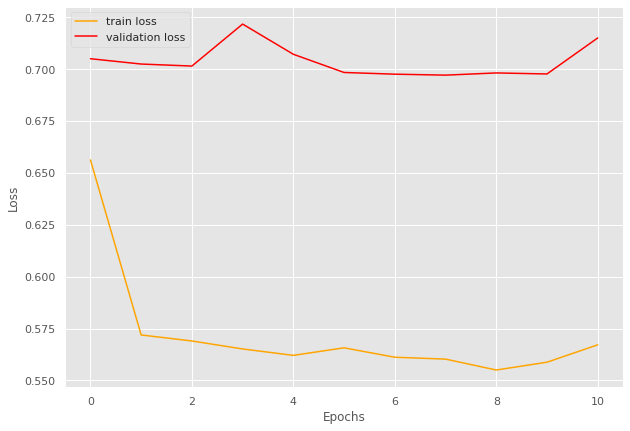

sampling data ...127442
Coarse label 2 Epoch 1
-------------------------------


100%|██████████| 51/51 [00:51<00:00,  1.02s/batch, loss=0.687]


train loss 0.6870796435019549, validation loss 0.769509243965149, validation accuracy 0.9101123595505618
Coarse label 2 Epoch 2
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.51batch/s, loss=0.606]


train loss 0.6056743778434455, validation loss 0.73898286819458, validation accuracy 0.9325842696629213
Coarse label 2 Epoch 3
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.54batch/s, loss=0.598]


INFO: Early stopping counter 1 of 5
train loss 0.5977025043730643, validation loss 0.7544633984565735, validation accuracy 0.9185393258426966
Coarse label 2 Epoch 4
-------------------------------


100%|██████████| 51/51 [00:19<00:00,  2.56batch/s, loss=0.592]


train loss 0.5923785193293702, validation loss 0.7307294130325317, validation accuracy 0.9410112359550562
Coarse label 2 Epoch 5
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.53batch/s, loss=0.592]


train loss 0.5924045782463223, validation loss 0.7248939394950866, validation accuracy 0.9466292134831461
Coarse label 2 Epoch 6
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.54batch/s, loss=0.598]


INFO: Early stopping counter 2 of 5
train loss 0.5975315699390337, validation loss 0.7356189370155335, validation accuracy 0.9382022471910112
Coarse label 2 Epoch 7
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.55batch/s, loss=0.587]


train loss 0.5868537893482283, validation loss 0.713188648223877, validation accuracy 0.9550561797752809
Coarse label 2 Epoch 8
-------------------------------


100%|██████████| 51/51 [00:20<00:00,  2.49batch/s, loss=0.588]


INFO: Early stopping counter 3 of 5
train loss 0.587554907097536, validation loss 0.7594033479690552, validation accuracy 0.9185393258426966
Coarse label 2 Epoch 9
-------------------------------


100%|██████████| 51/51 [00:19<00:00,  2.56batch/s, loss=0.586]


INFO: Early stopping counter 4 of 5
train loss 0.5856905649690067, validation loss 0.7372446775436401, validation accuracy 0.9353932584269663
Coarse label 2 Epoch 10
-------------------------------


100%|██████████| 51/51 [00:19<00:00,  2.56batch/s, loss=0.582]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9622166246851386 and loss 0.6821770568688711


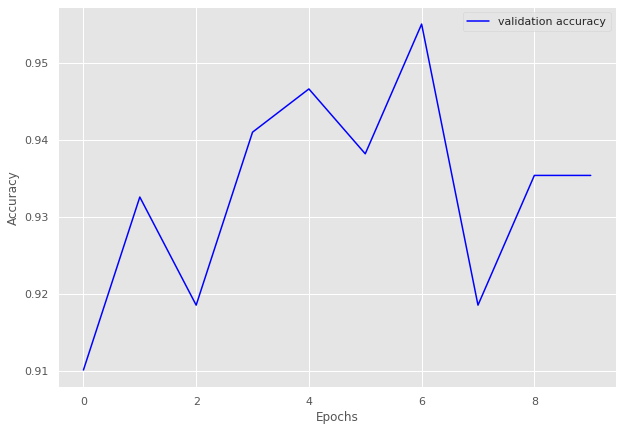

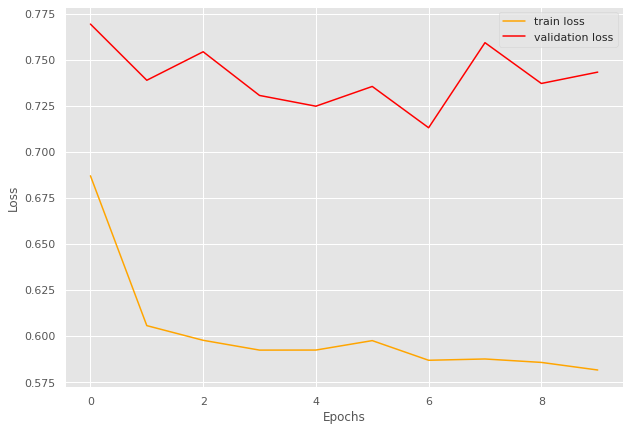

sampling data ...127442
Coarse label 4 Epoch 1
-------------------------------


100%|██████████| 122/122 [00:49<00:00,  2.49batch/s, loss=1.3] 


train loss 1.299384605689127, validation loss 1.3315205115538378, validation accuracy 0.9304750869061413
Coarse label 4 Epoch 2
-------------------------------


100%|██████████| 122/122 [00:48<00:00,  2.51batch/s, loss=1.21]


train loss 1.2103127309533417, validation loss 1.2969047473027155, validation accuracy 0.9617612977983777
Coarse label 4 Epoch 3
-------------------------------


100%|██████████| 122/122 [00:48<00:00,  2.51batch/s, loss=1.2]


train loss 1.1989790465010972, validation loss 1.2952014758036687, validation accuracy 0.9617612977983777
Coarse label 4 Epoch 4
-------------------------------


100%|██████████| 122/122 [00:48<00:00,  2.52batch/s, loss=1.2]


INFO: Early stopping counter 1 of 5
train loss 1.1973937798718937, validation loss 1.3073061888034527, validation accuracy 0.9536500579374276
Coarse label 4 Epoch 5
-------------------------------


100%|██████████| 122/122 [00:49<00:00,  2.49batch/s, loss=1.19]


INFO: Early stopping counter 2 of 5
train loss 1.1939672446641765, validation loss 1.3006584552618174, validation accuracy 0.9582850521436849
Coarse label 4 Epoch 6
-------------------------------


100%|██████████| 122/122 [00:49<00:00,  2.48batch/s, loss=1.19]


train loss 1.1941505602148712, validation loss 1.2858657195017889, validation accuracy 0.9710312862108922
Coarse label 4 Epoch 7
-------------------------------


100%|██████████| 122/122 [00:48<00:00,  2.50batch/s, loss=1.19]


INFO: Early stopping counter 3 of 5
train loss 1.1907096905786483, validation loss 1.3015347627493052, validation accuracy 0.9582850521436849
Coarse label 4 Epoch 8
-------------------------------


100%|██████████| 122/122 [00:48<00:00,  2.52batch/s, loss=1.19]


INFO: Early stopping counter 4 of 5
train loss 1.1857628021083895, validation loss 1.286920400766226, validation accuracy 0.9675550405561993
Coarse label 4 Epoch 9
-------------------------------


100%|██████████| 122/122 [00:52<00:00,  2.31batch/s, loss=1.19]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9677754677754677 and loss 1.2753788630167644


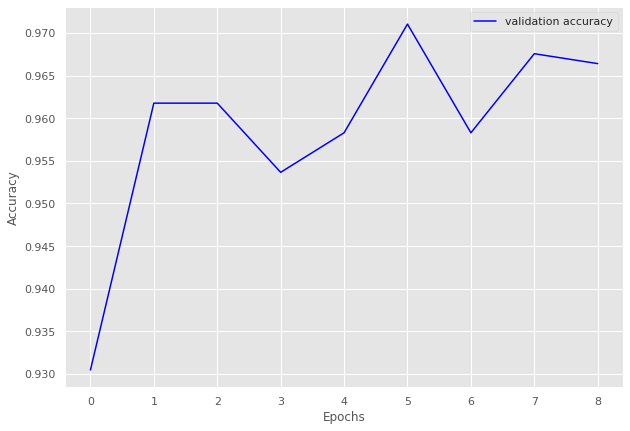

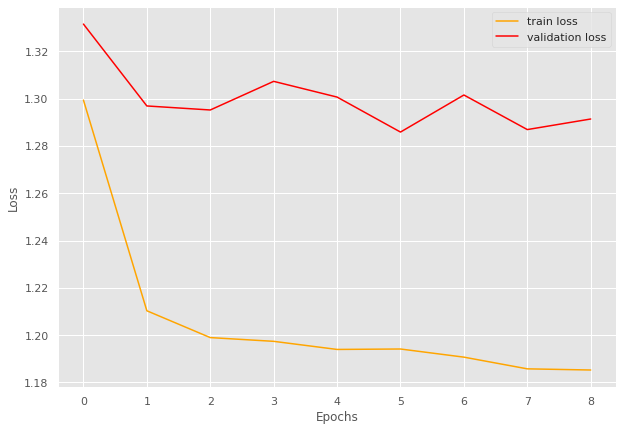

sampling data ...127442
Coarse label 5 Epoch 1
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.51batch/s, loss=1.01]


train loss 1.0050940705883888, validation loss 1.01149327479876, validation accuracy 0.9669703872437357
Coarse label 5 Epoch 2
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.50batch/s, loss=0.941]


INFO: Early stopping counter 1 of 5
train loss 0.941268470979506, validation loss 1.014277572815235, validation accuracy 0.9635535307517085
Coarse label 5 Epoch 3
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.50batch/s, loss=0.933]


train loss 0.9329952813925282, validation loss 1.0067760485869188, validation accuracy 0.969248291571754
Coarse label 5 Epoch 4
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.50batch/s, loss=0.926]


INFO: Early stopping counter 2 of 5
train loss 0.9260114272755962, validation loss 1.017127656019651, validation accuracy 0.9601366742596811
Coarse label 5 Epoch 5
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.53batch/s, loss=0.925]


train loss 0.9250223723150068, validation loss 1.0058087339768043, validation accuracy 0.9703872437357631
Coarse label 5 Epoch 6
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.52batch/s, loss=0.923]


train loss 0.9227465511329712, validation loss 1.0018421044716468, validation accuracy 0.9749430523917996
Coarse label 5 Epoch 7
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.53batch/s, loss=0.92] 


train loss 0.9195648244311733, validation loss 0.9977658482698294, validation accuracy 0.9783599088838268
Coarse label 5 Epoch 8
-------------------------------


100%|██████████| 124/124 [00:49<00:00,  2.52batch/s, loss=0.918]


INFO: Early stopping counter 3 of 5
train loss 0.9176949945188337, validation loss 0.9997968811255235, validation accuracy 0.9760820045558086
Coarse label 5 Epoch 9
-------------------------------


100%|██████████| 124/124 [00:56<00:00,  2.20batch/s, loss=0.916]


train loss 0.9158300238270913, validation loss 0.9883066094838656, validation accuracy 0.9886104783599089
Coarse label 5 Epoch 10
-------------------------------


100%|██████████| 124/124 [01:42<00:00,  1.21batch/s, loss=0.914]


INFO: Early stopping counter 4 of 5
train loss 0.9144111549662005, validation loss 1.0022057203146129, validation accuracy 0.9738041002277904
Coarse label 5 Epoch 11
-------------------------------


100%|██████████| 124/124 [01:36<00:00,  1.28batch/s, loss=0.917]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9785276073619632 and loss 0.9879246433575948


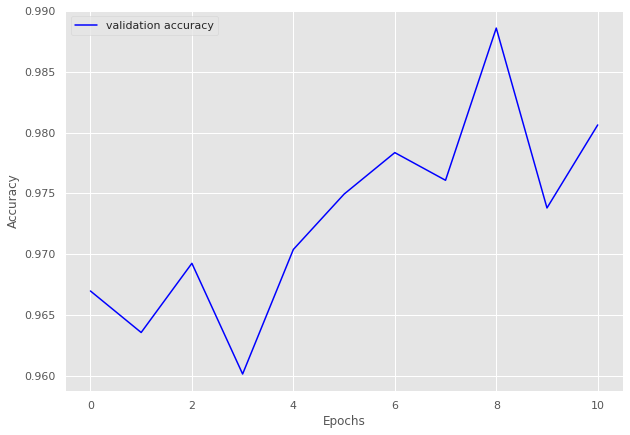

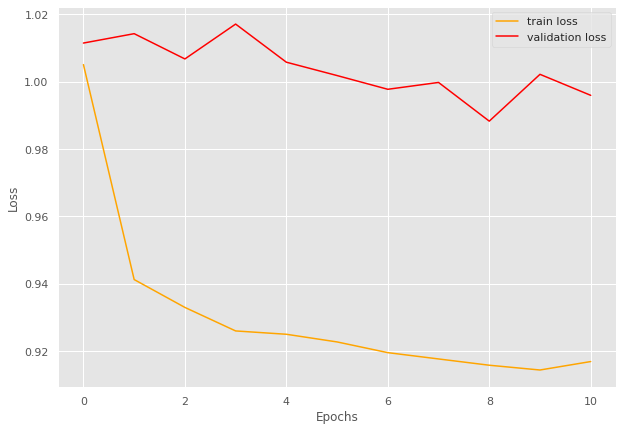

sampling data ...127442
Coarse label 6 Epoch 1
-------------------------------


100%|██████████| 196/196 [01:16<00:00,  2.56batch/s, loss=1.29]


train loss 1.292423308503871, validation loss 1.297005636351449, validation accuracy 0.9273381294964029
Coarse label 6 Epoch 2
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.54batch/s, loss=1.24]


INFO: Early stopping counter 1 of 5
train loss 1.2361918207334013, validation loss 1.3014040163585119, validation accuracy 0.920863309352518
Coarse label 6 Epoch 3
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.54batch/s, loss=1.22]


train loss 1.2246635702191566, validation loss 1.290484036718096, validation accuracy 0.935251798561151
Coarse label 6 Epoch 4
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.53batch/s, loss=1.22]


INFO: Early stopping counter 2 of 5
train loss 1.217951591525759, validation loss 1.3088274002075195, validation accuracy 0.9158273381294963
Coarse label 6 Epoch 5
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.53batch/s, loss=1.22]


train loss 1.2198020688125066, validation loss 1.2903696923028856, validation accuracy 0.9345323741007194
Coarse label 6 Epoch 6
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.53batch/s, loss=1.21]


train loss 1.2133815270297381, validation loss 1.2896001849855696, validation accuracy 0.9330935251798561
Coarse label 6 Epoch 7
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.53batch/s, loss=1.21]


train loss 1.2100800573825836, validation loss 1.2851754426956177, validation accuracy 0.939568345323741
Coarse label 6 Epoch 8
-------------------------------


100%|██████████| 196/196 [01:16<00:00,  2.55batch/s, loss=1.21]


train loss 1.2102537574816723, validation loss 1.2790628217515492, validation accuracy 0.9446043165467626
Coarse label 6 Epoch 9
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.52batch/s, loss=1.21]


INFO: Early stopping counter 3 of 5
train loss 1.2050151131591018, validation loss 1.2794673102242606, validation accuracy 0.9431654676258993
Coarse label 6 Epoch 10
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.54batch/s, loss=1.21]


train loss 1.2063614209087528, validation loss 1.278570021901812, validation accuracy 0.9453237410071943
Coarse label 6 Epoch 11
-------------------------------


100%|██████████| 196/196 [01:17<00:00,  2.53batch/s, loss=1.2]


INFO: Early stopping counter 4 of 5
train loss 1.2034542019269905, validation loss 1.286978767031715, validation accuracy 0.9359712230215828
Coarse label 6 Epoch 12
-------------------------------


100%|██████████| 196/196 [01:16<00:00,  2.55batch/s, loss=1.2]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.944516129032258 and loss 1.271899516383807


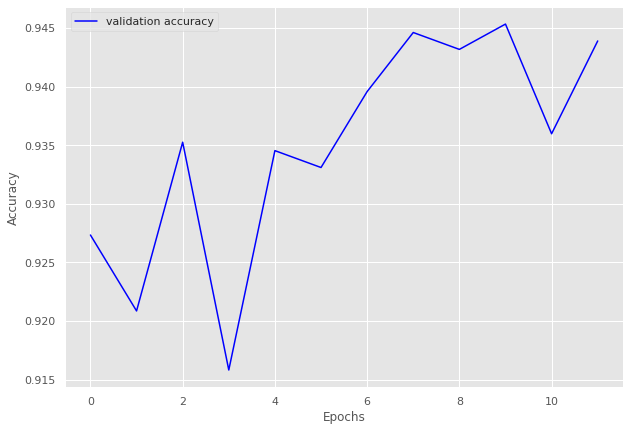

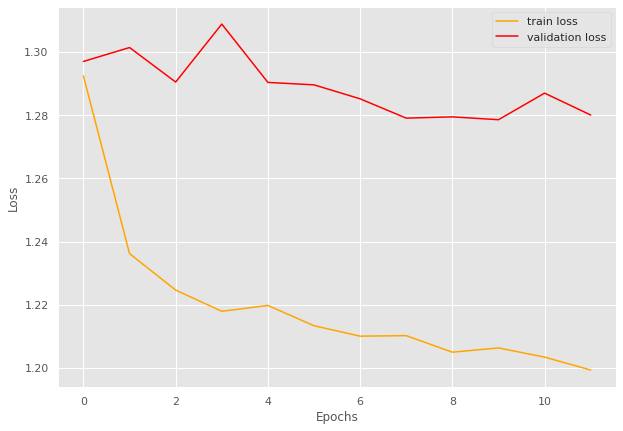

sampling data ...127442
Coarse label 7 Epoch 1
-------------------------------


100%|██████████| 303/303 [02:02<00:00,  2.48batch/s, loss=2.15]


train loss 2.1488714639109747, validation loss 2.0924560048363428, validation accuracy 0.8491620111731844
Coarse label 7 Epoch 2
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.49batch/s, loss=2.02]


train loss 2.020082925805951, validation loss 2.071085001483108, validation accuracy 0.8654562383612663
Coarse label 7 Epoch 3
-------------------------------


100%|██████████| 303/303 [02:00<00:00,  2.51batch/s, loss=2]   


train loss 2.0025957862142683, validation loss 2.0625348885854087, validation accuracy 0.8715083798882681
Coarse label 7 Epoch 4
-------------------------------


100%|██████████| 303/303 [04:14<00:00,  1.19batch/s, loss=1.99]


train loss 1.989020605685294, validation loss 2.0620657928062207, validation accuracy 0.8733705772811918
Coarse label 7 Epoch 5
-------------------------------


100%|██████████| 303/303 [06:43<00:00,  1.33s/batch, loss=1.98]


INFO: Early stopping counter 1 of 5
train loss 1.9815074433587958, validation loss 2.063075202884096, validation accuracy 0.8733705772811918
Coarse label 7 Epoch 6
-------------------------------


100%|██████████| 303/303 [02:46<00:00,  1.82batch/s, loss=1.98]


train loss 1.9773139269045084, validation loss 2.0470021312887017, validation accuracy 0.8901303538175046
Coarse label 7 Epoch 7
-------------------------------


100%|██████████| 303/303 [02:00<00:00,  2.51batch/s, loss=1.97]


train loss 1.9705328473163517, validation loss 2.031118389331933, validation accuracy 0.904562383612663
Coarse label 7 Epoch 8
-------------------------------


100%|██████████| 303/303 [02:08<00:00,  2.36batch/s, loss=1.96]


INFO: Early stopping counter 2 of 5
train loss 1.9620283027686696, validation loss 2.041699120492646, validation accuracy 0.8924581005586593
Coarse label 7 Epoch 9
-------------------------------


100%|██████████| 303/303 [02:07<00:00,  2.37batch/s, loss=1.96]


INFO: Early stopping counter 3 of 5
train loss 1.9561472202685013, validation loss 2.0410599636309072, validation accuracy 0.8938547486033519
Coarse label 7 Epoch 10
-------------------------------


100%|██████████| 303/303 [02:01<00:00,  2.50batch/s, loss=1.96]


INFO: Early stopping counter 4 of 5
train loss 1.9579257414285893, validation loss 2.041824236060634, validation accuracy 0.8933891992551211
Coarse label 7 Epoch 11
-------------------------------


100%|██████████| 303/303 [02:07<00:00,  2.39batch/s, loss=1.96]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9046822742474916 and loss 2.0222343174186914


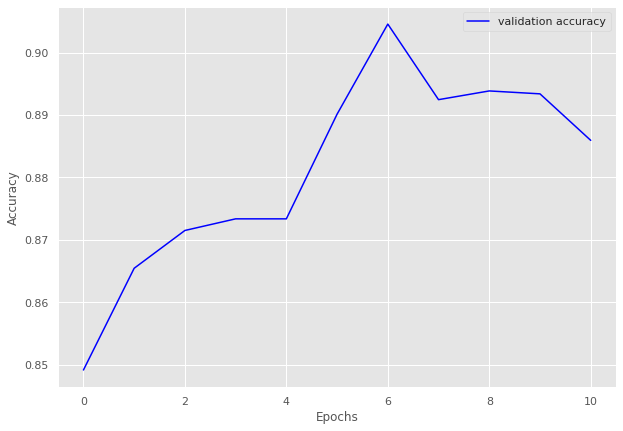

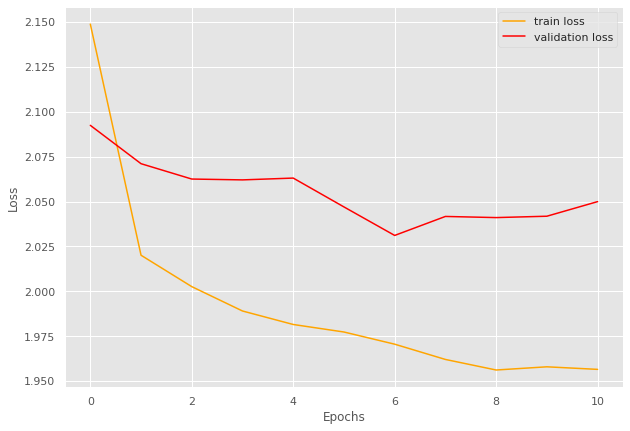

sampling data ...127442
Coarse label 8 Epoch 1
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.48batch/s, loss=1.5] 


train loss 1.5012842050769872, validation loss 1.510592758655548, validation accuracy 0.8810408921933085
Coarse label 8 Epoch 2
-------------------------------


100%|██████████| 114/114 [00:44<00:00,  2.54batch/s, loss=1.38]


train loss 1.3813977858476472, validation loss 1.4851811329523723, validation accuracy 0.9045848822800495
Coarse label 8 Epoch 3
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.51batch/s, loss=1.37]


train loss 1.3683805591181706, validation loss 1.4734617471694946, validation accuracy 0.9144981412639405
Coarse label 8 Epoch 4
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.52batch/s, loss=1.37]


INFO: Early stopping counter 1 of 5
train loss 1.366164019233302, validation loss 1.480295091867447, validation accuracy 0.9083023543990086
Coarse label 8 Epoch 5
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.51batch/s, loss=1.35]


train loss 1.3493650137332447, validation loss 1.4608077506224315, validation accuracy 0.9244114002478315
Coarse label 8 Epoch 6
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.50batch/s, loss=1.35]


INFO: Early stopping counter 2 of 5
train loss 1.3516253201585067, validation loss 1.467969685792923, validation accuracy 0.919454770755886
Coarse label 8 Epoch 7
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.53batch/s, loss=1.34]


INFO: Early stopping counter 3 of 5
train loss 1.341916219184273, validation loss 1.4675206045309703, validation accuracy 0.9206939281288724
Coarse label 8 Epoch 8
-------------------------------


100%|██████████| 114/114 [00:45<00:00,  2.53batch/s, loss=1.34]


INFO: Early stopping counter 4 of 5
train loss 1.3388752853661252, validation loss 1.4640469650427501, validation accuracy 0.9219330855018587
Coarse label 8 Epoch 9
-------------------------------


100%|██████████| 114/114 [01:32<00:00,  1.24batch/s, loss=1.34]


train loss 1.3375359606324582, validation loss 1.4596455593903859, validation accuracy 0.9268897149938042
Coarse label 8 Epoch 10
-------------------------------


100%|██████████| 114/114 [01:40<00:00,  1.13batch/s, loss=1.34]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9244444444444444 and loss 1.4413879769189017


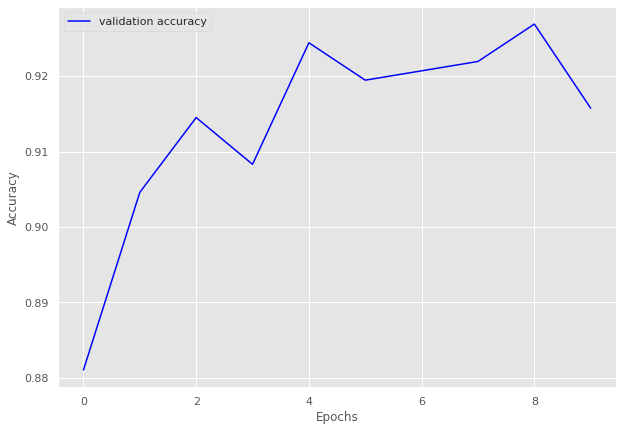

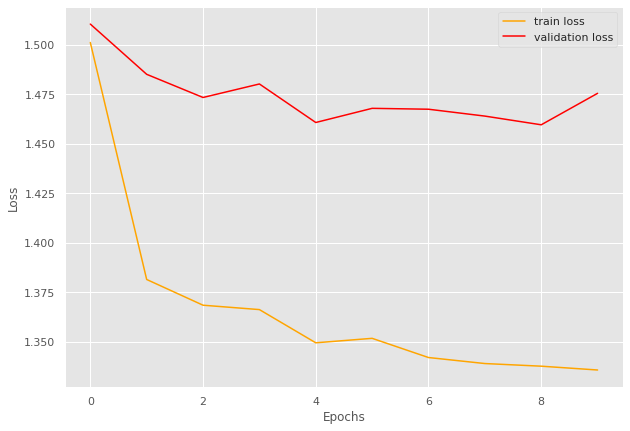

sampling data ...127442
Coarse label 9 Epoch 1
-------------------------------


100%|██████████| 31/31 [00:16<00:00,  1.93batch/s, loss=0.639]


train loss 0.6393567016047816, validation loss 0.7432801922162374, validation accuracy 0.9954128440366973
Coarse label 9 Epoch 2
-------------------------------


100%|██████████| 31/31 [00:11<00:00,  2.60batch/s, loss=0.566]


train loss 0.566259091900241, validation loss 0.7428241570790609, validation accuracy 0.9954128440366973
Coarse label 9 Epoch 3
-------------------------------


100%|██████████| 31/31 [00:12<00:00,  2.57batch/s, loss=0.557]


train loss 0.5567271901715186, validation loss 0.7383011976877848, validation accuracy 1.0
Coarse label 9 Epoch 4
-------------------------------


100%|██████████| 31/31 [00:11<00:00,  2.61batch/s, loss=0.555]


train loss 0.5548316759447898, validation loss 0.735413134098053, validation accuracy 1.0
Coarse label 9 Epoch 5
-------------------------------


100%|██████████| 31/31 [00:11<00:00,  2.60batch/s, loss=0.556]


INFO: Early stopping counter 1 of 5
train loss 0.5564041310741056, validation loss 0.737362265586853, validation accuracy 1.0
Coarse label 9 Epoch 6
-------------------------------


100%|██████████| 31/31 [00:12<00:00,  2.54batch/s, loss=0.556]


INFO: Early stopping counter 2 of 5
train loss 0.5559826531717854, validation loss 0.7488967974980673, validation accuracy 0.9954128440366973
Coarse label 9 Epoch 7
-------------------------------


100%|██████████| 31/31 [00:11<00:00,  2.58batch/s, loss=0.555]


INFO: Early stopping counter 3 of 5
train loss 0.5546637811968403, validation loss 0.7606390515963236, validation accuracy 0.9770642201834863
Coarse label 9 Epoch 8
-------------------------------


100%|██████████| 31/31 [00:11<00:00,  2.60batch/s, loss=0.553]


INFO: Early stopping counter 4 of 5
train loss 0.5534365177154541, validation loss 0.7447001735369364, validation accuracy 0.9908256880733946
Coarse label 9 Epoch 9
-------------------------------


100%|██████████| 31/31 [00:12<00:00,  2.57batch/s, loss=0.555]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9959183673469387 and loss 0.7405541936556498


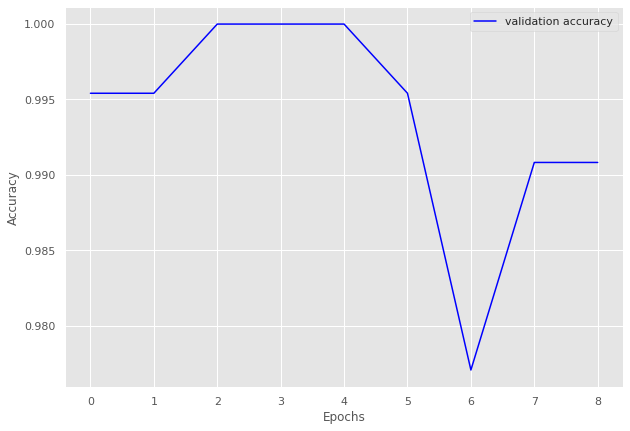

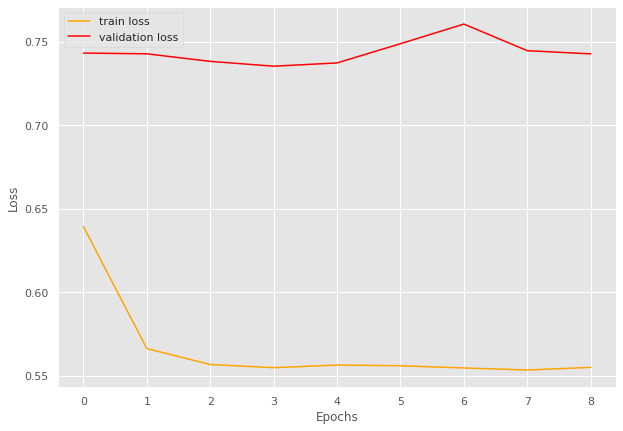

sampling data ...127442
Coarse label 10 Epoch 1
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.745]


train loss 0.7451208407680193, validation loss 0.7835073981966291, validation accuracy 0.8582677165354331
Coarse label 10 Epoch 2
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.645]


train loss 0.6450356609291501, validation loss 0.7629091228757586, validation accuracy 0.8818897637795275
Coarse label 10 Epoch 3
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.63] 


train loss 0.6302341396609942, validation loss 0.7418966293334961, validation accuracy 0.9015748031496063
Coarse label 10 Epoch 4
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.52batch/s, loss=0.613]


train loss 0.6133923596805997, validation loss 0.7243436404636928, validation accuracy 0.9153543307086615
Coarse label 10 Epoch 5
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.52batch/s, loss=0.608]


INFO: Early stopping counter 1 of 5
train loss 0.6077679933773147, validation loss 0.7347921984536308, validation accuracy 0.905511811023622
Coarse label 10 Epoch 6
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.51batch/s, loss=0.613]


INFO: Early stopping counter 2 of 5
train loss 0.6127233256896337, validation loss 0.7442392110824585, validation accuracy 0.8956692913385826
Coarse label 10 Epoch 7
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.606]


INFO: Early stopping counter 3 of 5
train loss 0.6058986956874529, validation loss 0.7383626614298139, validation accuracy 0.905511811023622
Coarse label 10 Epoch 8
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.52batch/s, loss=0.601]


train loss 0.6010756393273672, validation loss 0.7126255120549884, validation accuracy 0.9291338582677166
Coarse label 10 Epoch 9
-------------------------------


100%|██████████| 72/72 [00:28<00:00,  2.51batch/s, loss=0.594]


INFO: Early stopping counter 4 of 5
train loss 0.594471338722441, validation loss 0.7153055923325675, validation accuracy 0.9291338582677166
Coarse label 10 Epoch 10
-------------------------------


100%|██████████| 72/72 [00:29<00:00,  2.42batch/s, loss=0.588]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9081272084805654 and loss 0.7208192944526672


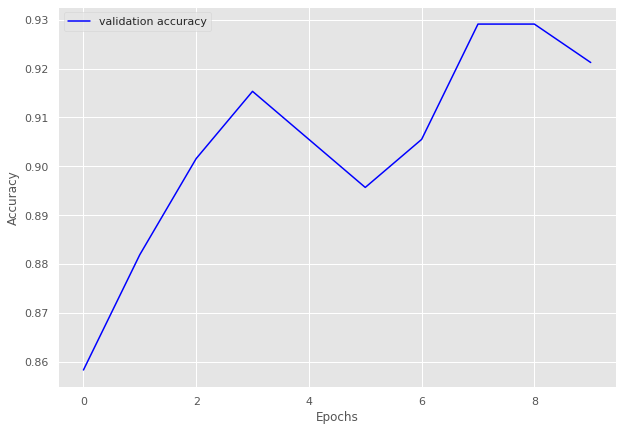

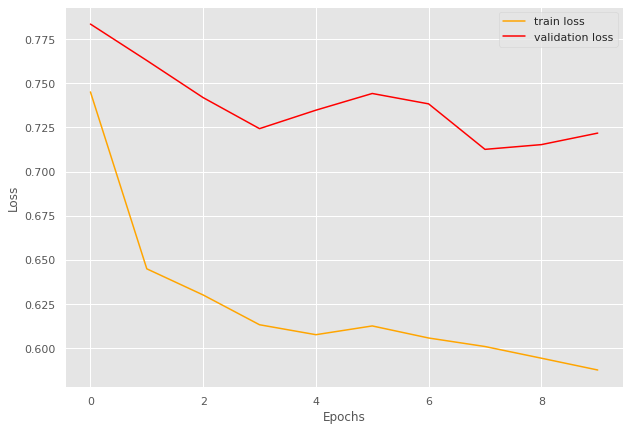

sampling data ...127442
Coarse label 11 Epoch 1
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.54batch/s, loss=0.722]


train loss 0.722485232860484, validation loss 0.7505883693695068, validation accuracy 0.9129129129129129
Coarse label 11 Epoch 2
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.54batch/s, loss=0.615]


INFO: Early stopping counter 1 of 5
train loss 0.6153242410497463, validation loss 0.7511586546897888, validation accuracy 0.9369369369369369
Coarse label 11 Epoch 3
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.52batch/s, loss=0.596]


train loss 0.5955424663868356, validation loss 0.7386425256729126, validation accuracy 0.9279279279279279
Coarse label 11 Epoch 4
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.52batch/s, loss=0.596]


INFO: Early stopping counter 2 of 5
train loss 0.5956942946352857, validation loss 0.7447278618812561, validation accuracy 0.9279279279279279
Coarse label 11 Epoch 5
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.55batch/s, loss=0.603]


train loss 0.6032990737164274, validation loss 0.7307074069976807, validation accuracy 0.9459459459459459
Coarse label 11 Epoch 6
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.51batch/s, loss=0.594]


train loss 0.5935881251984454, validation loss 0.7259015202522278, validation accuracy 0.9369369369369369
Coarse label 11 Epoch 7
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.52batch/s, loss=0.585]


INFO: Early stopping counter 3 of 5
train loss 0.5854201215378781, validation loss 0.7457649111747742, validation accuracy 0.948948948948949
Coarse label 11 Epoch 8
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.50batch/s, loss=0.582]


train loss 0.5822874713451305, validation loss 0.7003877520561218, validation accuracy 0.960960960960961
Coarse label 11 Epoch 9
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.54batch/s, loss=0.584]


train loss 0.5835070673455584, validation loss 0.6963356375694275, validation accuracy 0.9669669669669669
Coarse label 11 Epoch 10
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.53batch/s, loss=0.582]


INFO: Early stopping counter 4 of 5
train loss 0.5822661341504848, validation loss 0.7129704594612122, validation accuracy 0.963963963963964
Coarse label 11 Epoch 11
-------------------------------


100%|██████████| 47/47 [00:18<00:00,  2.53batch/s, loss=0.584]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9354838709677419 and loss 0.738555634021759


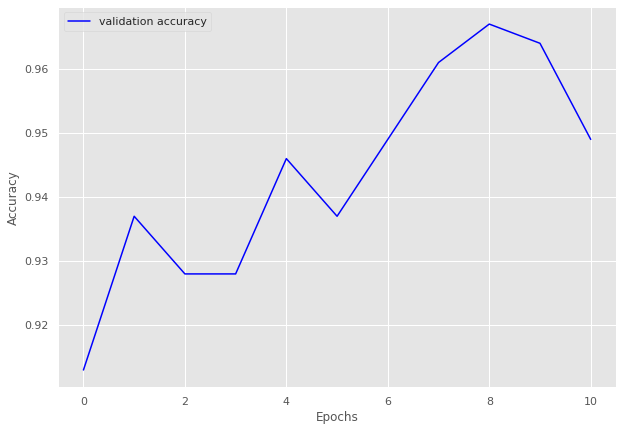

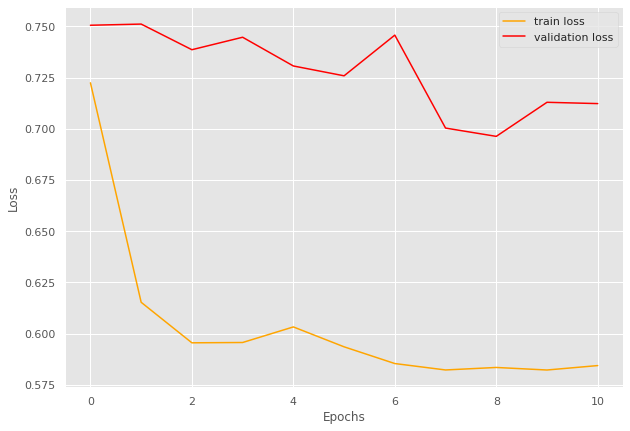

sampling data ...127442
Coarse label 12 Epoch 1
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.59batch/s, loss=0.385]


train loss 0.3853879749774933, validation loss 0.4350074330965678, validation accuracy 0.9903381642512077
Coarse label 12 Epoch 2
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.59batch/s, loss=0.323]


train loss 0.32258155941963196, validation loss 0.4306510388851166, validation accuracy 0.9855072463768116
Coarse label 12 Epoch 3
-------------------------------


100%|██████████| 30/30 [00:12<00:00,  2.47batch/s, loss=0.32] 


INFO: Early stopping counter 1 of 5
train loss 0.32045301198959353, validation loss 0.43605028589566547, validation accuracy 0.9855072463768116
Coarse label 12 Epoch 4
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.57batch/s, loss=0.317]


INFO: Early stopping counter 2 of 5
train loss 0.3174533466498057, validation loss 0.43657758831977844, validation accuracy 0.9806763285024155
Coarse label 12 Epoch 5
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.59batch/s, loss=0.317]


INFO: Early stopping counter 3 of 5
train loss 0.31670043369134265, validation loss 0.4340829054514567, validation accuracy 0.9855072463768116
Coarse label 12 Epoch 6
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.55batch/s, loss=0.317]


train loss 0.3170811474323273, validation loss 0.4289403160413106, validation accuracy 0.9903381642512077
Coarse label 12 Epoch 7
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.58batch/s, loss=0.323]


INFO: Early stopping counter 4 of 5
train loss 0.32276590168476105, validation loss 0.43567166725794476, validation accuracy 0.9855072463768116
Coarse label 12 Epoch 8
-------------------------------


100%|██████████| 30/30 [00:11<00:00,  2.59batch/s, loss=0.32] 


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 1.0 and loss 0.4180213510990143


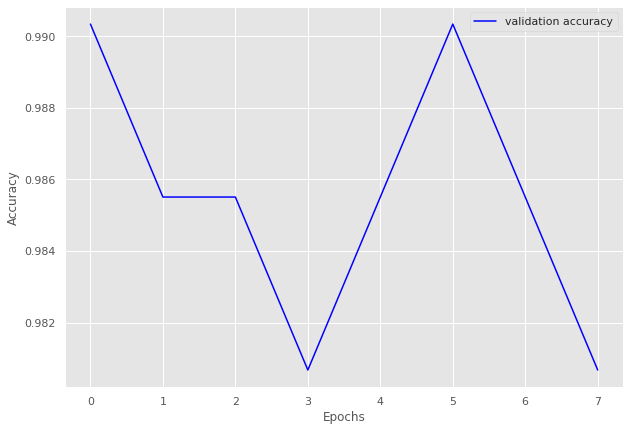

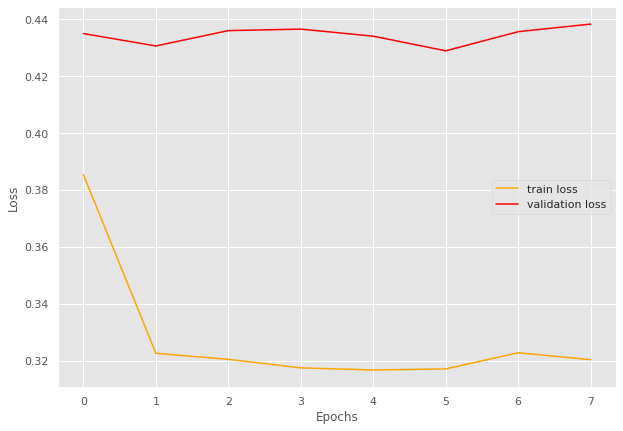

sampling data ...127442
Coarse label 13 Epoch 1
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.51batch/s, loss=1.02]


train loss 1.0174363660812378, validation loss 1.0208309021863071, validation accuracy 0.9689703808180536
Coarse label 13 Epoch 2
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.53batch/s, loss=0.944]


train loss 0.9442631351947784, validation loss 1.0184149579568342, validation accuracy 0.9661495063469676
Coarse label 13 Epoch 3
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.52batch/s, loss=0.932]


train loss 0.9322605490684509, validation loss 1.0082703774625605, validation accuracy 0.9802538787023978
Coarse label 13 Epoch 4
-------------------------------


100%|██████████| 100/100 [00:40<00:00,  2.48batch/s, loss=0.934]


INFO: Early stopping counter 1 of 5
train loss 0.9342014354467392, validation loss 1.041649422862313, validation accuracy 0.9605077574047954
Coarse label 13 Epoch 5
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.51batch/s, loss=0.93]


train loss 0.9301968514919281, validation loss 1.0078358866951682, validation accuracy 0.9802538787023978
Coarse label 13 Epoch 6
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.51batch/s, loss=0.925]


INFO: Early stopping counter 2 of 5
train loss 0.9245830500125884, validation loss 1.0082867470654575, validation accuracy 0.9788434414668548
Coarse label 13 Epoch 7
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.53batch/s, loss=0.918]


train loss 0.9183329099416733, validation loss 1.0029204433614558, validation accuracy 0.9844851904090268
Coarse label 13 Epoch 8
-------------------------------


100%|██████████| 100/100 [00:40<00:00,  2.50batch/s, loss=0.919]


INFO: Early stopping counter 3 of 5
train loss 0.9190904635190964, validation loss 1.0080043890259482, validation accuracy 0.9788434414668548
Coarse label 13 Epoch 9
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.51batch/s, loss=0.919]


INFO: Early stopping counter 4 of 5
train loss 0.91869225025177, validation loss 1.018483275716955, validation accuracy 0.9844851904090268
Coarse label 13 Epoch 10
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.53batch/s, loss=0.917]


train loss 0.9169252425432205, validation loss 1.0016773505644365, validation accuracy 0.9858956276445698
Coarse label 13 Epoch 11
-------------------------------


100%|██████████| 100/100 [00:40<00:00,  2.50batch/s, loss=0.919]


train loss 0.9186559695005417, validation loss 0.9989385550672357, validation accuracy 0.9915373765867419
Coarse label 13 Epoch 12
-------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.52batch/s, loss=0.915]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9822784810126582 and loss 1.0014311571915944


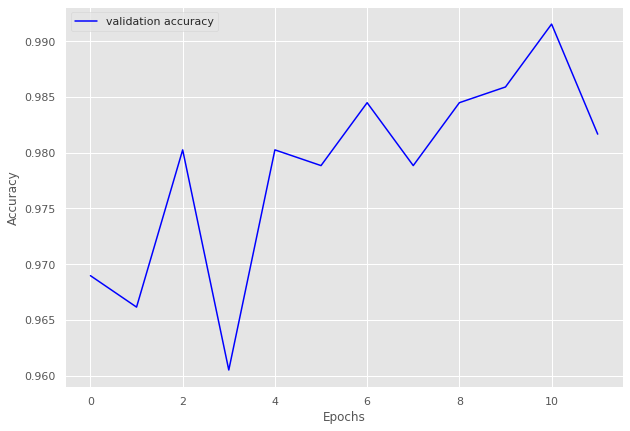

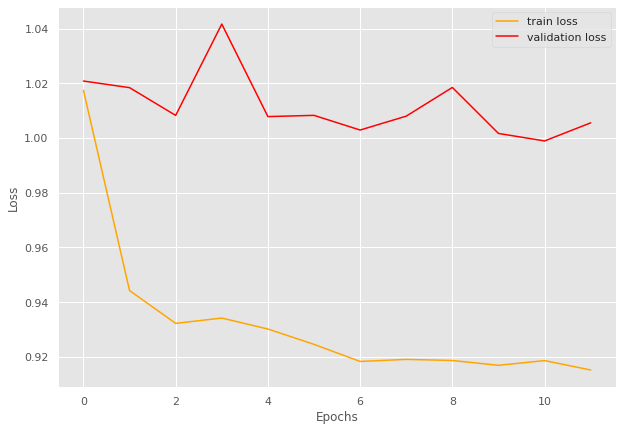

sampling data ...127442
Coarse label 15 Epoch 1
-------------------------------


100%|██████████| 81/81 [00:32<00:00,  2.52batch/s, loss=1.3] 


train loss 1.2960491430612258, validation loss 1.3535600453615189, validation accuracy 0.8432055749128919
Coarse label 15 Epoch 2
-------------------------------


100%|██████████| 81/81 [00:32<00:00,  2.53batch/s, loss=1.18]


train loss 1.180554512106342, validation loss 1.3196637034416199, validation accuracy 0.8763066202090593
Coarse label 15 Epoch 3
-------------------------------


100%|██████████| 81/81 [00:31<00:00,  2.53batch/s, loss=1.17]


INFO: Early stopping counter 1 of 5
train loss 1.1675240669721438, validation loss 1.3205428421497345, validation accuracy 0.867595818815331
Coarse label 15 Epoch 4
-------------------------------


100%|██████████| 81/81 [00:32<00:00,  2.52batch/s, loss=1.16]


INFO: Early stopping counter 2 of 5
train loss 1.161575120172383, validation loss 1.328634351491928, validation accuracy 0.8588850174216028
Coarse label 15 Epoch 5
-------------------------------


100%|██████████| 81/81 [00:31<00:00,  2.55batch/s, loss=1.16]


INFO: Early stopping counter 3 of 5
train loss 1.1581446712399706, validation loss 1.3213708996772766, validation accuracy 0.8710801393728222
Coarse label 15 Epoch 6
-------------------------------


100%|██████████| 81/81 [00:45<00:00,  1.77batch/s, loss=1.15]


INFO: Early stopping counter 4 of 5
train loss 1.1504968169294758, validation loss 1.3239552527666092, validation accuracy 0.8658536585365854
Coarse label 15 Epoch 7
-------------------------------


100%|██████████| 81/81 [01:45<00:00,  1.31s/batch, loss=1.15]


train loss 1.1506085837328877, validation loss 1.3179491609334946, validation accuracy 0.8693379790940766
Coarse label 15 Epoch 8
-------------------------------


100%|██████████| 81/81 [01:57<00:00,  1.44s/batch, loss=1.14]


train loss 1.1441511533878468, validation loss 1.3131253570318222, validation accuracy 0.8763066202090593
Coarse label 15 Epoch 9
-------------------------------


100%|██████████| 81/81 [02:01<00:00,  1.50s/batch, loss=1.14]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.8642745709828393 and loss 1.2820493221282958


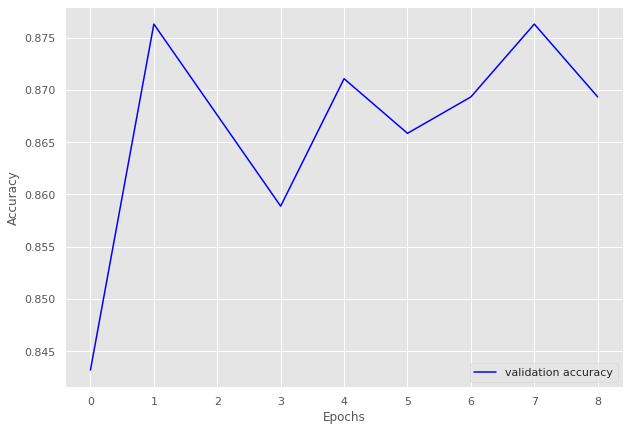

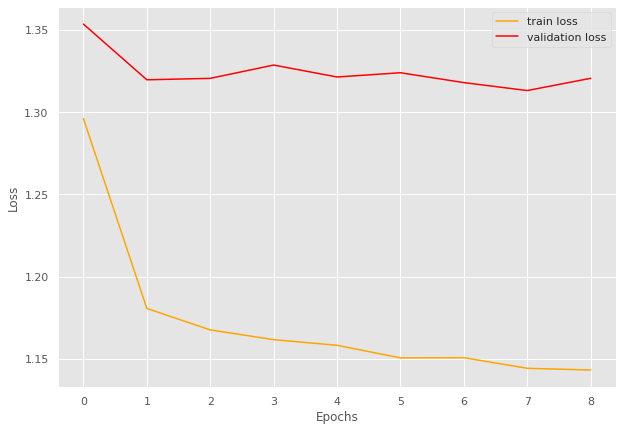

sampling data ...127442
Coarse label 17 Epoch 1
-------------------------------


100%|██████████| 82/82 [01:47<00:00,  1.31s/batch, loss=0.895]


train loss 0.8954663727341629, validation loss 0.9418649077415466, validation accuracy 0.9036144578313253
Coarse label 17 Epoch 2
-------------------------------


100%|██████████| 82/82 [01:48<00:00,  1.32s/batch, loss=0.815]


train loss 0.8146585167908087, validation loss 0.9061544007725186, validation accuracy 0.919104991394148
Coarse label 17 Epoch 3
-------------------------------


100%|██████████| 82/82 [01:27<00:00,  1.06s/batch, loss=0.806]


INFO: Early stopping counter 1 of 5
train loss 0.8057678305521244, validation loss 0.9123102161619399, validation accuracy 0.9139414802065404
Coarse label 17 Epoch 4
-------------------------------


100%|██████████| 82/82 [00:33<00:00,  2.45batch/s, loss=0.804]


INFO: Early stopping counter 2 of 5
train loss 0.8040960278452897, validation loss 0.913998113738166, validation accuracy 0.9122203098106713
Coarse label 17 Epoch 5
-------------------------------


100%|██████████| 82/82 [00:32<00:00,  2.50batch/s, loss=0.803]


INFO: Early stopping counter 3 of 5
train loss 0.8025791739545217, validation loss 0.910933686627282, validation accuracy 0.9173838209982789
Coarse label 17 Epoch 6
-------------------------------


100%|██████████| 82/82 [00:32<00:00,  2.53batch/s, loss=0.797]


train loss 0.7971366098741206, validation loss 0.8873383005460104, validation accuracy 0.9380378657487092
Coarse label 17 Epoch 7
-------------------------------


100%|██████████| 82/82 [00:32<00:00,  2.52batch/s, loss=0.797]


INFO: Early stopping counter 4 of 5
train loss 0.7974668348707804, validation loss 0.9305717481507195, validation accuracy 0.9208261617900172
Coarse label 17 Epoch 8
-------------------------------


100%|██████████| 82/82 [00:32<00:00,  2.52batch/s, loss=0.788]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9429892141756548 and loss 0.8783178329467773


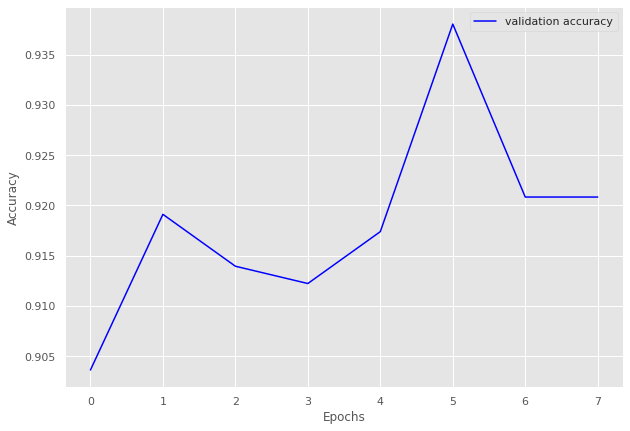

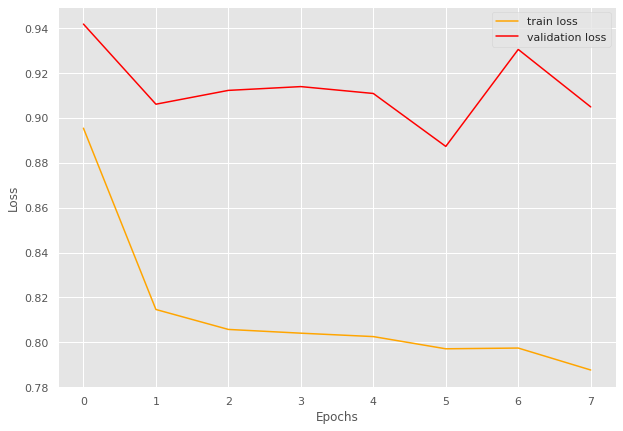

sampling data ...127442
Coarse label 19 Epoch 1
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.51batch/s, loss=0.383]


train loss 0.38304387906502035, validation loss 0.44843539595603943, validation accuracy 0.9851485148514851
Coarse label 19 Epoch 2
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.54batch/s, loss=0.326]


train loss 0.3256804162058337, validation loss 0.4271073341369629, validation accuracy 0.9900990099009901
Coarse label 19 Epoch 3
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.51batch/s, loss=0.317]


INFO: Early stopping counter 1 of 5
train loss 0.3166822575289628, validation loss 0.4275572995344798, validation accuracy 0.9900990099009901
Coarse label 19 Epoch 4
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.56batch/s, loss=0.316]


train loss 0.31574384816761675, validation loss 0.4190830886363983, validation accuracy 1.0
Coarse label 19 Epoch 5
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.53batch/s, loss=0.314]


INFO: Early stopping counter 2 of 5
train loss 0.31408484639792605, validation loss 0.4209132194519043, validation accuracy 0.995049504950495
Coarse label 19 Epoch 6
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.57batch/s, loss=0.316]


INFO: Early stopping counter 3 of 5
train loss 0.31646824807956303, validation loss 0.4261449972788493, validation accuracy 0.9900990099009901
Coarse label 19 Epoch 7
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.53batch/s, loss=0.318]


INFO: Early stopping counter 4 of 5
train loss 0.3182860777295869, validation loss 0.4252160390218099, validation accuracy 0.995049504950495
Coarse label 19 Epoch 8
-------------------------------


100%|██████████| 29/29 [00:11<00:00,  2.60batch/s, loss=0.317]


INFO: Early stopping counter 5 of 5
INFO: Early stopping
Done! Saved model with test accuracy 0.9823008849557522 and loss 0.4443085690339406


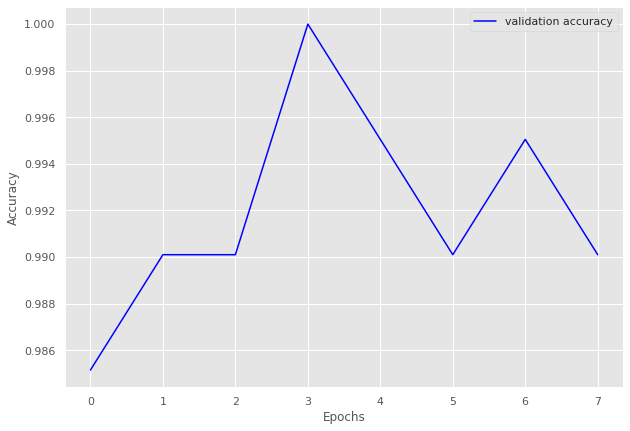

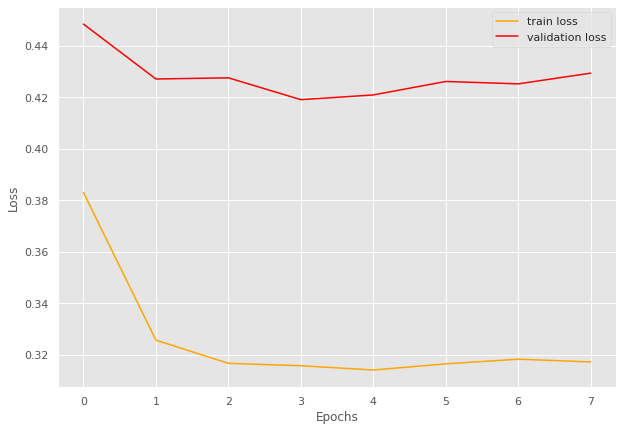

{0: 0.9253233208176888, 1: 0.9932659932659933, 2: 0.9622166246851386, 4: 0.9677754677754677, 5: 0.9785276073619632, 6: 0.944516129032258, 7: 0.9046822742474916, 8: 0.9244444444444444, 9: 0.9959183673469387, 10: 0.9081272084805654, 11: 0.9354838709677419, 12: 1.0, 13: 0.9822784810126582, 15: 0.8642745709828393, 17: 0.9429892141756548, 19: 0.9823008849557522}


In [49]:
fine_accuracies = {}
label_noise_str = str(label_noise).replace(".", "")

for coarse_label in range(0, number_of_clusters):
        if len(coarse_to_fine[coarse_label])>1:
            train_dl, val_dl, test_dl =  filter_data(main_dataset, test_dataset, filter_by_coarse=True, 
                    coarse_label=coarse_label, coarse_to_fine=coarse_to_fine, valid_size=0.1, 
                    batch_size=batch_size, data_fraction=1, seed=acorn)
            # Initialize the model
            model = Resnext50(len(coarse_to_fine[coarse_label]), name="hierarchical_fine_model_coarse_label_%s_noise%s_round_%s" %(coarse_label, label_noise_str, round_no))
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            model.to(device)
            loss_fn = torch.nn.CrossEntropyLoss().to(device)
            test_acc = train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,  mode="fine", 
                                                   coarse_label=coarse_label, lookup=coarse_to_fine[coarse_label], 
                                                   model_path = '../../../teamdrive/transmediasp/kate/models/hierarchical/%s.pth' %model.name )
            fine_accuracies[coarse_label] = test_acc
print(fine_accuracies)

In [55]:
#Evaluation of the whole model

#loading models
gc.collect() 
torch.cuda.empty_cache()
model_coarse = Resnext50(number_of_clusters, name='')
model_coarse.load_state_dict(torch.load('../../../teamdrive/transmediasp/kate/models/hierarchical/hierarchical_coarse_model_Resnext50_icons_%s_round%s.pth' %(label_noise_str, round_no)))
fine_models = {}
for i in range(0,number_of_clusters):
    if len(coarse_to_fine[i])>1:
        fine_model = Resnext50(len(coarse_to_fine[i]), name='')                 
        fine_models['fine_model_' + str(i)] = fine_model.load_state_dict(torch.load('../../../teamdrive/transmediasp/kate/models/hierarchical/hierarchical_fine_model_coarse_label_%s_noise%s_round_%s.pth' %(i, label_noise_str, round_no)))

coarse_predicts = []
targets = []
model_coarse.to(device)
model_coarse.eval()
for counter, (images, labels) in enumerate(dl_test):
    imageGPU = images.to(device)
    outputs = torch.Tensor.cpu(model_coarse(imageGPU))
    coarse_predicts.append(outputs.detach().numpy())
    targets.append(labels)
targets = np.hstack(targets)  

#reformat coarse prediction
coarse_prediction = np.vstack(coarse_predicts)

column_num = 0
for i in range(0, number_of_clusters):
    cluster_len = len(coarse_to_fine[i])
    for rep in range(cluster_len-1):
        coarse_prediction = np.insert(coarse_prediction, column_num, coarse_prediction[:,column_num], axis=1)
    column_num +=cluster_len

fine_prediction= []

for i in range(0,number_of_clusters):
    gc.collect() 
    torch.cuda.empty_cache()
    predicts = []
    print("Evaluating fine model %s" %i)
    if len(coarse_to_fine[i]) == 1:
        fine_prediction.append(np.ones((len(coarse_prediction),1)))
    else:
        fine_model = fine_models['fine_model_%s' %i]
        fine_model.to(device)
        fine_model.eval()
        for counter, (images, labels) in enumerate(dl_test):
            imageGPU = images.to(device)
            outputs = torch.Tensor.cpu(fine_model(imageGPU))
            predicts.append(outputs.detach().numpy())   
        predicts = np.vstack(predicts)
        fine_prediction.append(predicts)                          

#reformat fine_prediction
fine_prediction = np.hstack(fine_prediction)
result = np.multiply(fine_prediction, coarse_prediction)
result = np.argmax(result, axis=1)
result_decoded = [stacked_fine_labels[i] for i in result]   
final_acc = accuracy_score(targets, result_decoded) 
print("overall accuracy with %s label noise is %s" %(label_noise, final_acc))

Evaluating fine model 0


AttributeError: '_IncompatibleKeys' object has no attribute 'to'